## 1 Introduction
The MNIST dataset is a comprehensive collection of handwritten digits ranging from 0
to 9. It includes 60,000 grayscale images for training and 10,000 images for testing. Each
image is 28 by 28 pixels, with pixel values ranging from 0 to 255. In this project, we
focus on analyzing a subset of the test dataset and apply Principal Component Analysis
(PCA) to reduce dimensionality.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import os

# Create output directory if it doesn't exist
os.makedirs('output', exist_ok=True)

c:\Users\anshu\.conda\envs\batch5\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


## Load and Preprocess Dataset

Dataset shape: (4000, 28, 28)
Number of samples: 4000, Number of features: 784
Data ranges from 0.0 to 1.0


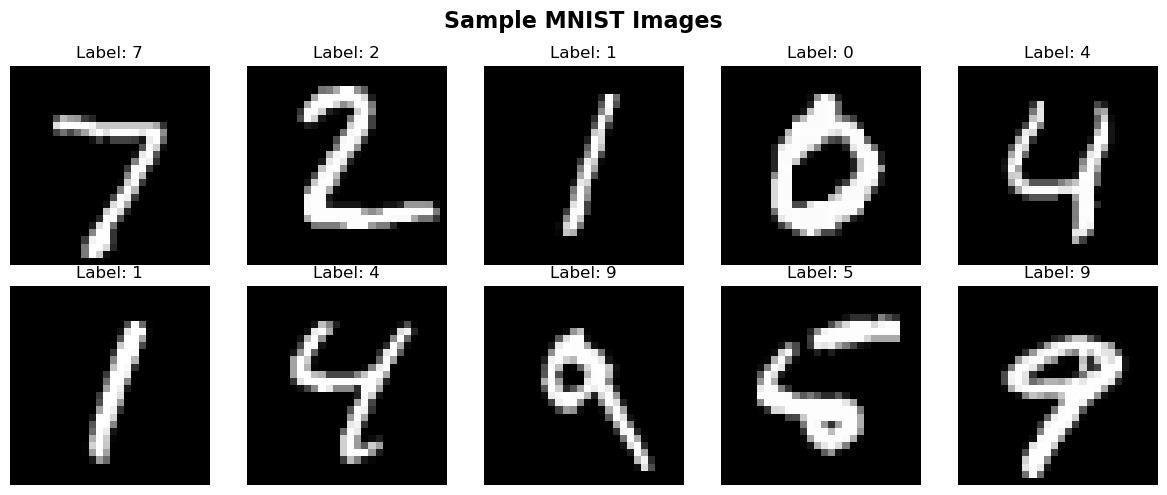

In [2]:
#Load MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

#User first 4000 samples from test set
x_images = x_test[:4000]
y_labels = y_test[:4000]

x_images = x_images.astype('float32') / 255.0
n_samples, height, width = x_images.shape
nsamples = int(n_samples)
height = int(height)
width = int(width)
n_features = int(height * width)
imagw_shape = (height, width)
x_images_reshaped = x_images.reshape((nsamples, n_features))

print(f"Dataset shape: {x_images.shape}")
print(f"Number of samples: {nsamples}, Number of features: {n_features}")
print(f"Data ranges from {x_images_reshaped.min()} to {x_images_reshaped.max()}")

#Visualize some sample images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i in range(10):
    ax = axes[i // 5, i % 5]
    ax.imshow(x_images[i], cmap='gray')
    ax.set_title(f"Label: {y_labels[i]}")
    ax.axis('off')
plt.suptitle("Sample MNIST Images", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('output/sample_mnist_images.png', dpi=300, bbox_inches='tight')
plt.show()

## Task 1: Eigen Decomposition
Compute the eigen decomposition of the sample covariance matrix.

In [3]:
x_mean = np.mean(x_images_reshaped, axis=0)
x_centered = x_images_reshaped - x_mean

print(f"Centered data shape: {x_centered.shape}")
print(f"Mean of centered data (should be close to 0): {np.mean(x_centered):.10f}")

Centered data shape: (4000, 784)
Mean of centered data (should be close to 0): -0.0000000411


In [4]:
#Compute covariance matrix
cov_matrix = np.cov(x_centered.T, bias=True)
print(f"Covariance matrix shape: {cov_matrix.shape}")

Covariance matrix shape: (784, 784)


In [5]:
#Eigen decomposition
print("Performing eigen decomposition...")
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

#Sort eigenvalues and eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

print(f"Number of eigenvalues: {len(eigenvalues)}")
print(f"Top 5 eigenvalues: {eigenvalues[:5]}")
for i in range(5):
    print(f"Eigenvalue {i+1}: {eigenvalues[i]:.6f}")

Performing eigen decomposition...
Number of eigenvalues: 784
Top 5 eigenvalues: [4.84325198 3.70861637 2.87301724 2.52086075 2.37690856]
Eigenvalue 1: 4.843252
Eigenvalue 2: 3.708616
Eigenvalue 3: 2.873017
Eigenvalue 4: 2.520861
Eigenvalue 5: 2.376909


In [6]:
#Calculate variance explained
variance_explained = eigenvalues / np.sum(eigenvalues)
cumulative_variance = np.cumsum(variance_explained)

print("Variance explained by top components:")
print("-" * 40)
print(f"{'Component':<15}{'Individual %':<20}{'Cumulative %':<20}")
print("-" * 40)
for i in [1, 5, 10, 20, 50, 100, 200, 500]:
    print(f"First {i:<10}{variance_explained[i-1]*100:<20.4f}{cumulative_variance[i-1]*100:<20.4f}")

print("-" * 40)

Variance explained by top components:
----------------------------------------
Component      Individual %        Cumulative %        
----------------------------------------
First 1         9.7140              9.7140              
First 5         4.7673              32.7380             
First 10        2.2518              47.7169             
First 20        1.1534              63.5306             
First 50        0.3434              82.3426             
First 100       0.1030              91.7155             
First 200       0.0281              97.0034             
First 500       0.0010              99.9592             
----------------------------------------


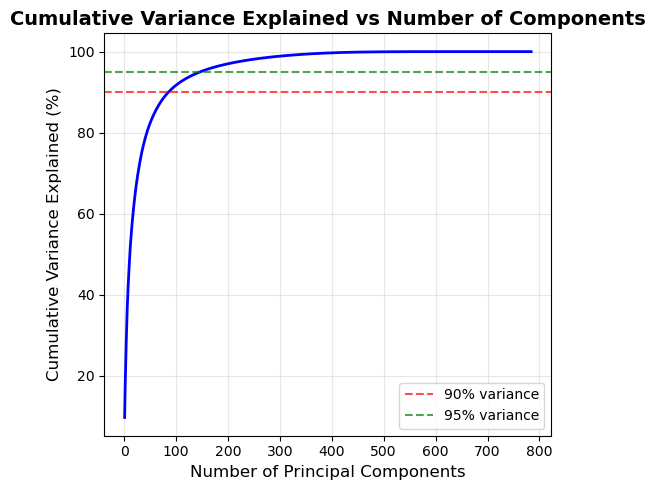

In [7]:
#Plot cumulative variance
plt.figure(figsize=(10 , 5))

# Full range plot
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, len(cumulative_variance) + 1), cumulative_variance * 100, 'b-', linewidth=2)
plt.xlabel("Number of Principal Components", fontsize=12)
plt.ylabel("Cumulative Variance Explained (%)", fontsize=12)
plt.title("Cumulative Variance Explained vs Number of Components", fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axhline(y=90, color='r', linestyle='--', label='90% variance', alpha=0.7)
plt.axhline(y=95, color='g', linestyle='--', label='95% variance', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.savefig('output/task1_cumulative_variance_full.png', dpi=300, bbox_inches='tight')
plt.show()

## Task 2: PCA for Dimensionality Reduction

Apply PCA via eigen decomposition to reduce the dimensionality of the images for each
p ∈ {50, 250, 500}.

In [8]:
# Define number of components to test
p_values = [50, 250, 500]

# Store transformed data for different p values
x_reduced = {}

print("Applying PCA for dimensionality reduction...")
print("=" * 45)

for p in p_values:
    #Select top p eigenvectors
    W_pca = eigenvectors[:, :p]
    
    #Project data onto new subspace
    x_pca = np.dot(x_centered, W_pca)
    x_reduced[p] = x_pca
    
    print(f"\np = {p}:")
    print(f"Original data shape: {x_images_reshaped.shape[1]}")
    print(f"Transformed data shape: {x_pca.shape[1]}")
    print(f"Dimensionality reduction: {((n_features - p) / n_features) * 100:.2f}%")
    print(f"Variance retained: {cumulative_variance[p-1]*100:.2f}%")

Applying PCA for dimensionality reduction...

p = 50:
Original data shape: 784
Transformed data shape: 50
Dimensionality reduction: 93.62%
Variance retained: 82.34%

p = 250:
Original data shape: 784
Transformed data shape: 250
Dimensionality reduction: 68.11%
Variance retained: 98.14%

p = 500:
Original data shape: 784
Transformed data shape: 500
Dimensionality reduction: 36.22%
Variance retained: 99.96%


## Task 3: Data Reconstruction
Using the reduced data from Task 2, reconstruct the original images. Use the property
of orthonormal matrices for reconstruction.

In [9]:
# Store reconstructed data for different p values
x_reconstructed = {}

print("\nReconstructing images from reduced data...")
print("=" * 40)

for p in p_values:
    #Select top p eigenvectors
    w_pca = eigenvectors[:, :p]
    
    #Project data onto new subspace
    #x_pca = x_reduced[p]
    
    #Reconstruct data from reduced representation using orthonormal property
    x_recon = np.dot(x_reduced[p], w_pca.T) + x_mean
    x_reconstructed[p] = x_recon
    
    print(f"\np = {p}:")
    print(f"Reconstructed data shape: {x_recon.shape}")
    print(f"Data range: [{x_recon.min():.4f}, {x_recon.max():.4f}]")


Reconstructing images from reduced data...

p = 50:
Reconstructed data shape: (4000, 784)
Data range: [-0.5705, 1.5007]

p = 250:
Reconstructed data shape: (4000, 784)
Data range: [-0.2961, 1.3592]

p = 500:
Reconstructed data shape: (4000, 784)
Data range: [-0.1669, 1.1758]


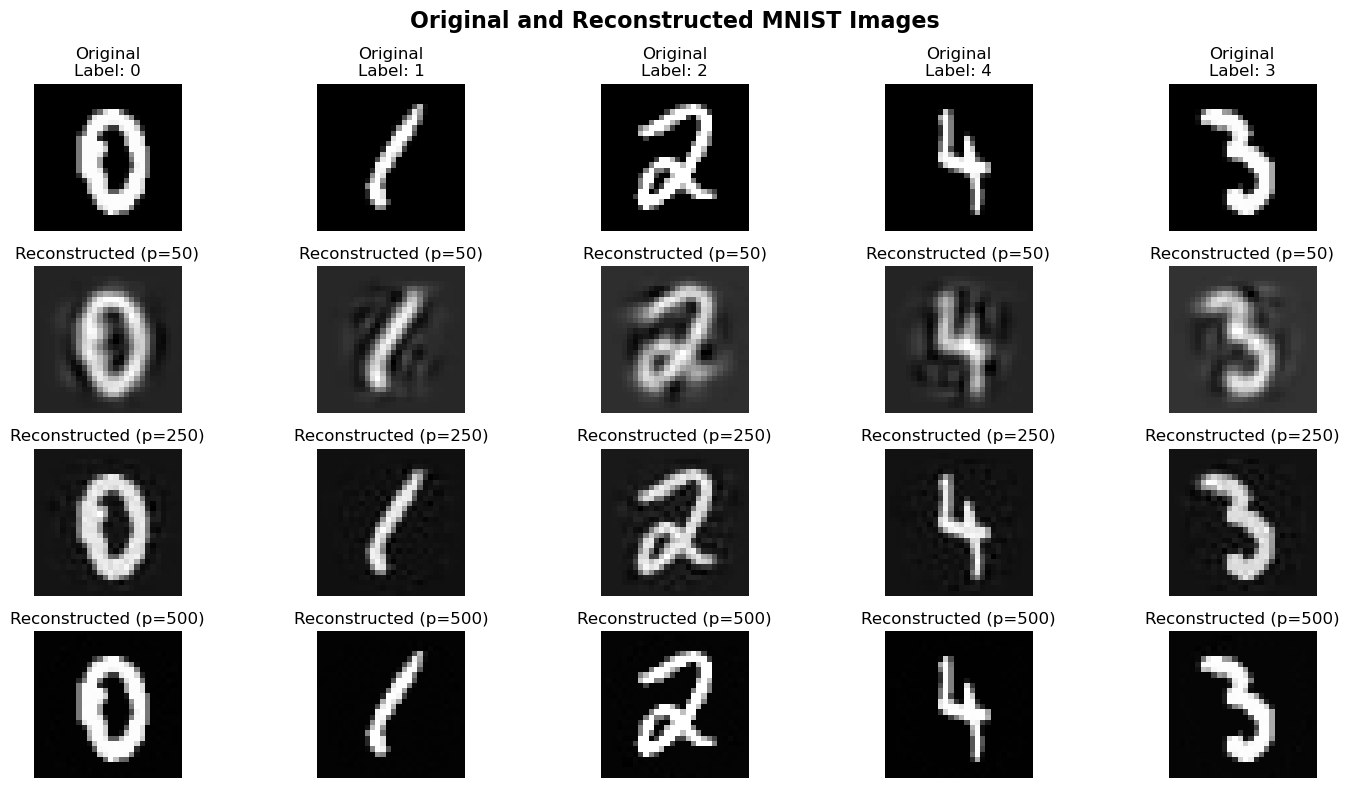

In [10]:
# Visualize original and reconstructed images
# Select random samples to visualize
sample_indices = np.random.choice(nsamples, size=5, replace=False)
fig, axes = plt.subplots(len(p_values) + 1, len(sample_indices), figsize=(15, 8))
for i, idx in enumerate(sample_indices):
    # Original image
    axes[0, i].imshow(x_images_reshaped[idx].reshape(imagw_shape), cmap='gray')
    axes[0, i].set_title(f"Original\nLabel: {y_labels[idx]}")
    axes[0, i].axis('off')
    
    # Reconstructed images for different p values
    for j, p in enumerate(p_values):
        axes[j + 1, i].imshow(x_reconstructed[p][idx].reshape(imagw_shape), cmap='gray')
        axes[j + 1, i].set_title(f"Reconstructed (p={p})")
        axes[j + 1, i].axis('off')

plt.suptitle("Original and Reconstructed MNIST Images", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('output/task3_original_reconstructed_images.png', dpi=300, bbox_inches='tight')
plt.show()

## Task 4: Error Comparison (PSNR)
Compare the error between the original and reconstructed images for 5 randomly selected
images using Peak Signal-to-Noise Ratio (PSNR).

In [11]:
# Function to calculate PSNR between original and reconstructed images
def calculate_psnr(original, reconstructed):
    mse = np.mean((original - reconstructed) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0  # Since images are normalized between 0 and 1
    psnr = 10 * np.log10(max_pixel ** 2 / mse)
    return psnr

In [12]:
# Calculate PSNR for 5 random samples
print("\nCalculating PSNR for reconstructed images...")
print("=" * 80)
print(f"{'Image Index':<15} {'Label':<15}{'p=50':<15}{'P=250':<15} {'p=500':<15}")
print("-" * 80)

psnr_results = []

for idx in sample_indices:
    original_image = x_images[idx].flatten()
    label = y_labels[idx]
    psnr_values = {}
    for p in p_values:
        recon_image = x_reconstructed[p][idx]
        recon_image = np.clip(recon_image, 0, 1)  # Ensure pixel values are in [0, 1]
        psnr = calculate_psnr(original_image, recon_image)
        psnr_values[p] = psnr
    psnr_results.append({
        'index': idx,
        'label': label,
        'psnr': psnr_values
    })

    print(f"{idx:<15} {y_labels[idx]:<15}{psnr_values[50]:<15.2f}{psnr_values[250]:<15.2f}{psnr_values[500]:<15.2f}")
print("-" * 80)

# Calculate average PSNR for all samples
avg_psnr = {p: np.mean([result['psnr'][p] for result in psnr_results]) for p in p_values}
print("\nAverage PSNR across all samples:")
for p in p_values:
    print(f"p = {p}: Average PSNR = {avg_psnr[p]:.2f} dB")
print("=" * 80)


Calculating PSNR for reconstructed images...
Image Index     Label          p=50           P=250           p=500          
--------------------------------------------------------------------------------
1558            0              22.06          32.15          57.26          
107             1              24.43          33.32          58.67          
1506            2              17.95          28.90          54.32          
2708            4              21.09          33.66          60.90          
2991            3              20.47          31.48          56.12          
--------------------------------------------------------------------------------

Average PSNR across all samples:
p = 50: Average PSNR = 21.20 dB
p = 250: Average PSNR = 31.90 dB
p = 500: Average PSNR = 57.45 dB


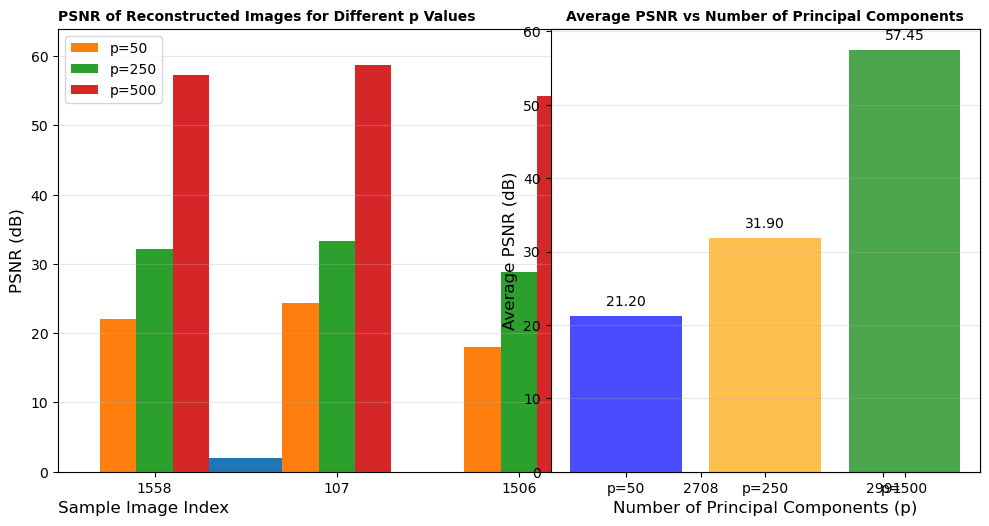

In [13]:
# Plot PSNR comparison
plt.figure(figsize=(10, 6))
plt.bar(1,2,1)
x = np.arange(len(sample_indices))
width = 0.2
for i, p in enumerate(p_values):
    psnr_vals = [result['psnr'][p] for result in psnr_results]
    plt.bar(x + i * width, psnr_vals, width, label=f'p={p}')
plt.xlabel("Sample Image Index", fontsize=12, loc='left')
plt.ylabel("PSNR (dB)", fontsize=12)
plt.title("PSNR of Reconstructed Images for Different p Values", fontsize=10, loc='left', fontweight='bold')
plt.xticks(x + width, [str(idx) for idx in sample_indices])
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

#Bar plot for average PSNR
plt.subplot(1, 2, 2)
bars=plt.bar(range(len(p_values)), [avg_psnr[p] for p in p_values], color=['blue', 'orange', 'green'], alpha=0.7)
plt.xlabel("Number of Principal Components (p)", fontsize=12)
plt.ylabel("Average PSNR (dB)", fontsize=12)
plt.title("Average PSNR vs Number of Principal Components", fontsize=10, fontweight='bold')
plt.xticks(range(len(p_values)), [f'p={p}' for p in p_values])
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on top of bars
for i, p in enumerate(p_values):
    plt.text(i, avg_psnr[p] + 1, f"{avg_psnr[p]:.2f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('output/task4_psnr_comparison.png', dpi=300, bbox_inches='tight')
plt.show()